In [1]:
from queue import Queue
from threading import Thread
import sys
import time

class VideoWriter:
    def __init__(self, queue_size=50, timeout=3, frame_width=0, frame_height=0, video_out_file=None):
        # initialize the file video stream along with the boolean
        # used to indicate if the thread should be stopped or not
        self.queue_size = queue_size
        self.timeout = timeout
        self.stopped = False
        self.frame_width = frame_width
        self.frame_height = frame_height
        # initialize the queue used to store frames read from
        # the video file
        self.Q = Queue(maxsize=queue_size)
        self.video_out_file = video_out_file
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        self.out = cv2.VideoWriter(video_out_file, fourcc, 30.0, (frame_width, frame_height))

    def start(self):

#         fourcc = cv2.VideoWriter_fourcc(*'mjpg')
#         self.out = cv2.VideoWriter(filename=self.video_out_file, fourcc=fourcc, fps=30, 
#                               frameSize=(frame_width, frame_height), isColor=True)
        # start a thread to read frames from the file video stream
        self.t = Thread(target=self.write, args=())
        self.t.daemon = True
        self.t.start()
        time.sleep(1)
        return self

    def write(self):
        # keep looping infinitely
        while True:
            # if the thread indicator variable is set, stop the
            # thread
            if self.stopped:
                return

            # otherwise, ensure the queue has room in it
            if not self.Q.empty():
                frame = self.Q.get()
                self.out.write(frame)
#                     file_name = os.path.basename(frame_file)
#                     frame_new_file = os.path.join(self.video_out_file, file_name)
#                     cv2.imwrite(frame_new_file, frame)
                # add the frame to the queue
            else:
                print('empty')
                time.sleep(self.timeout)

    def add_frame(self, frame):
        self.Q.put(frame)



    def flush(self):
        while not self.Q.empty():
#             frame = self.Q.get()
#             self.out.write(frame)
            frame = self.Q.get()
            self.out.write(frame)
#                 file_name = os.path.basename(frame_file)
#                 frame_new_file = os.path.join(self.video_out_file, file_name)
#                 cv2.imwrite(frame_new_file, frame)

    def stop(self):
        # indicate that the thread should be stopped
        print('stopping')
        self.stopped = True
        self.t.join()
        self.flush()
        self.out.release()

    def close(self):
        self.stop()

In [2]:
import glob
import shutil
from osgeo import gdal
import cv2
import numpy as np
import skimage.transform as transform
import matplotlib.pyplot as plt

In [3]:
geotif_dsm_file =  '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/mapping/orthomosaics/observation088_dsm.tif'
geotif_image_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/mapping/orthomosaics/observation088_transparent_mosaic_group1.tif'
tracks_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/observation088/localizations/tracks_with_utm.npy' 
dsm_gtif = gdal.Open(geotif_dsm_file)
image_gtif = gdal.Open(geotif_image_file)
tracks = np.load(tracks_file)

In [4]:
dsm = dsm_gtif.GetRasterBand(1).ReadAsArray()
dsm_ave = np.min(dsm[dsm!= -10000])
dsm = np.where(dsm == -10000, dsm_ave, dsm)
elevation_r = dsm

bands = []
for band_num in range(1, 4):
    srcband = image_gtif.GetRasterBand(band_num)
    a = srcband.ReadAsArray()
    bands.append(a)
image_map = np.stack(bands, 2)


[102 117 119]


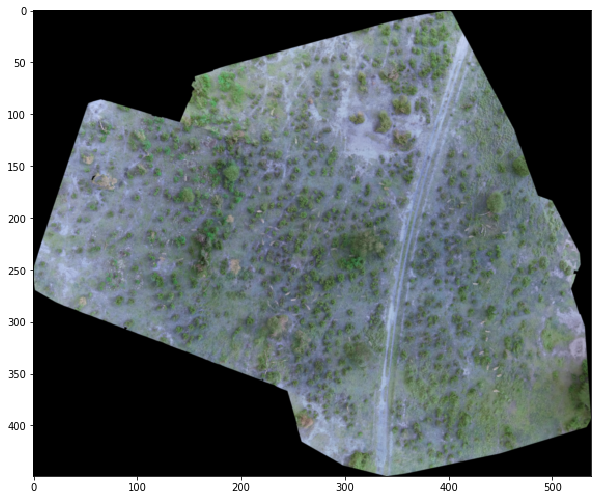

In [5]:
map_scaling = .1

background_map_image = transform.rescale(image_map, map_scaling, multichannel=True, mode='reflect', anti_aliasing=True)
background_map_image = np.uint8(background_map_image * 255)
background_map_image = cv2.cvtColor(background_map_image, cv2.COLOR_RGB2BGR)
print(background_map_image[200, 200])
plt.figure(figsize=(10,10))
plt.imshow(background_map_image)

In [6]:
# image scale of .5 means that the map is being used at .5 w .5 h compared to original
def utm_to_raster(x_utm, y_utm, x_origin, y_origin, pixel_width, pixel_height, image_scale):
    x_raster = int(((x_utm - x_origin) / pixel_width) * image_scale)  
#     y_raster = int((y_origin - y_utm) / -pixel_height)
    y_raster = int(((y_utm - y_origin) / pixel_height) * image_scale)
    return((x_raster, y_raster))


In [7]:
# Get an assortment of colors for plotting
colors = [(230, 25, 75),(255, 225, 25),(0, 130, 200),(245, 130, 48),(145, 30, 180),
          (70, 240, 240),(240, 50, 230),(210, 245, 60),(250, 190, 190),(0, 128, 128),
          (230, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195),
          (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255),
          (0, 0, 0), (60, 180, 75)] 

In [8]:
# Get information for converting between utm and raster coordinates
dsm_transform = dsm_gtif.GetGeoTransform()
x_origin = dsm_transform[0]
y_origin = dsm_transform[3]
pixel_width = dsm_transform[1]
pixel_height = dsm_transform[5]

In [9]:
video_writer = VideoWriter(frame_width=background_map_image.shape[1], frame_height=background_map_image.shape[0], video_out_file='test-video-2.mp4')
video_writer.start()
print('starting video writer')

empty
starting video writer
empty
empty
empty
empty
empty


In [10]:
track_length = 30000
for frame in range(track_length):
    if frame % 2000 == 0:
        print(frame)
    if frame % 3 == 0:

        background = np.copy(background_map_image)

        for track_ind, track in enumerate(tracks):
            rel_frame = frame - track['first_frame']
            utm_coord = track['track_utm'][rel_frame]
            x_rast, y_rast = utm_to_raster(utm_coord[0], utm_coord[1], x_origin, y_origin, pixel_width, pixel_height, map_scaling)
            cv2.circle(background, (x_rast, y_rast), 2, colors[track_ind], -1)
        video_writer.add_frame(background)
video_writer.close()

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
stopping


In [ ]:
video_writer.close()

In [21]:
for t in test_positions[0]:
    print((*t))

91 487
74 375
419 164
350 206
288 444
224 227
15 379
127 101
121 422
318 252


In [12]:
2 % 1.5


0.5